## Modelo

In [1]:
import os
import pandas as pd
import numpy as np

from keras import models, layers, regularizers, metrics, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.util import ngrams

import collections
import unicodedata

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('../data/interim/tweets_aos_fatos_saude.csv')

In [3]:
def preprocess_embeddings(embeddings_path, max_words, embedding_dim, word_index):
    
    # Strongly inspired by listings 6.10 and 6.11 of "Deep Learning with Python", Francois Chollet, Manning.
    
    embeddings_idx = {};
    embeddings_file = open(embeddings_path)
    for row in embeddings_file:
        split_row = row.split(' ')
        if len(split_row) > 51:
            word = ' '.join(split_row[0:len(split_row) - 50])
            values = np.asarray(split_row[-50:])
        else:
            word = split_row[0]
            values = np.asarray(split_row[1:])
        embeddings_idx[word] = values
    embeddings_file.close()
    print(str(len(embeddings_idx)) + " words detected.")
    
    embeddings_mat = np.zeros((max_words, embedding_dim))
    print(embeddings_mat.shape)
    
    for word, idx in word_index.items():
        if (idx < max_words):
            embedding_vector = embeddings_idx.get(word)
            if embedding_vector is not None:
                embeddings_mat[idx] = embedding_vector
    
    return embeddings_mat

def build_model_nlp_lstm(regression_problem, max_words, embedding_dim, max_len, pre_trained_embeddings, embeddings_matrix, lstm_bidirectional, lstm_layers_neurons, lstm_layers_recurrent_dropout, lstm_layers_dropout, hidden_layers_neurons, hidden_activation_function, L1_coeffs, L2_coeffs, hidden_layers_dropout, final_layer_neurons, final_activation_function, model_optimizer, loss_function, metrics):
    
    model = models.Sequential()
    model.add(layers.Embedding(max_words,embedding_dim,input_length = max_len))
    if (pre_trained_embeddings == True):
        model.layers[0].set_weights([embeddings_matrix])
        model.layers[0].trainable = False
        
    for i in range(len(lstm_layers_neurons)):
        if ((i == 0) & (len(lstm_layers_neurons) > 1)):
            return_sequences_bool = True
        else:
            return_sequences_bool = False
            
        if (lstm_bidirectional == True):
            model.add(
                layers.Bidirectional(
                    layers.LSTM(
                        lstm_layers_neurons[i],
                        return_sequences = return_sequences_bool, 
                        recurrent_dropout = lstm_layers_recurrent_dropout[i], 
                        dropout = lstm_layers_dropout[i]
                    )
                )
            )            
        else:
             model.add(
                 layers.LSTM(
                     lstm_layers_neurons[i],
                     return_sequences = return_sequences_bool, 
                     recurrent_dropout = lstm_layers_recurrent_dropout[i], 
                     dropout = lstm_layers_dropout[i]
                 )
             )
    
    for i in range(len(hidden_activation_function)):        
        model.add(
            layers.Dense(
                hidden_layers_neurons[i], 
                kernel_regularizer = regularizers.l1_l2(l1 = L1_coeffs[i], l2 =  L2_coeffs[i]),  
                activation=hidden_activation_function[i]
            )
        )
        if (hidden_layers_dropout[i] > 0.0):
            model.add(layers.Dropout(hidden_layers_dropout[i]))
            
    if regression_problem:
        model.add(layers.Dense(final_layer_neurons))
    else:
        model.add(
            layers.Dense(
                final_layer_neurons,
                activation = final_activation_function
            )
        )
            
    model.compile(optimizer = model_optimizer, loss = loss_function, metrics = metrics)    
    return model


def analyze_performances(hst, epochs):
    
    history_dict             = hst.history
    loss_values              = history_dict['loss']
    validation_loss_values   = history_dict['val_loss']
    acc_values               = history_dict['accuracy']
    validation_acc_values    = history_dict['val_accuracy']
    epochs                   = range(1,len(loss_values) + 1)
    fig, axes                = plt.subplots(1,2,figsize = (20,10))
    training_ts              = [loss_values, acc_values]
    validation_ts            = [validation_loss_values, validation_acc_values]
    metric_names             = ['loss', 'accuracy']
    for i in range(len(axes)):
        axes[i].plot(epochs,training_ts[i],color = 'r',label = 'training')
        axes[i].plot(epochs,validation_ts[i],color = 'b',label = 'validation')
        axes[i].set_xlabel('epoch')
        axes[i].set_ylabel(metric_names[i])
        axes[i].set_title(metric_names[i] + ' analysis')
        axes[i].set_xticks(np.arange(0,epochs[-1] + 1,5))
        axes[i].set_yticks(np.arange(0,1.1,0.1))
        axes[i].set_xlim([1,epochs[-1]])
        axes[i].set_ylim([0,1])
        axes[i].legend()
    plt.show()


def model_evaluation(model, x_test, y_test):
    
    predictions = model.predict_classes(x_test)
    matrix      = confusion_matrix(y_test,predictions.flatten())
    rel_matrix  = matrix/np.sum(matrix,axis = 0)
    fig, axes   = plt.subplots(1,2,figsize = (20,40))
    class_labels= np.unique(y_test)

    image1 = axes[0].imshow(matrix, cmap=plt.get_cmap('GnBu'))
    for (i, j), e in np.ndenumerate(matrix):
        axes[0].text(j, i, s = str(e), ha='center', va='center')
    axes[0].set_xticks(np.arange(0,len(class_labels), 1))
    axes[0].set_xticklabels(class_labels)
    axes[0].set_yticks(np.arange(0,len(class_labels), 1))
    axes[0].set_yticklabels(class_labels)
    axes[0].set_title('Confusion Matrix')
    
    image2 = axes[1].imshow(matrix/np.sum(matrix,axis = 0), cmap=plt.get_cmap('GnBu'))
    for (i, j), e in np.ndenumerate(rel_matrix):
        axes[1].text(j, i, s = str(np.round(e,2)), ha='center', va='center')
    axes[1].set_xticks(np.arange(0,len(class_labels), 1))
    axes[1].set_xticklabels(class_labels)
    axes[1].set_yticks(np.arange(0,len(class_labels), 1))
    axes[1].set_yticklabels(class_labels)
    plt.subplots_adjust(wspace = 0.5)
    axes[1].set_title('Confusion Matrix (Relative)')                      
    plt.show()

In [4]:
test_split                     = 0.2
regression_problem             = False
max_words                      = 20000
embedding_dim                  = 50
max_len                        = 250
pre_trained_embeddings         = True

# embedding de 50 dimensões já treinado obtidos em nilc
# http://www.nilc.icmc.usp.br/embeddings
pre_trained_embeddings_path    =  f'../data/raw/skip_s{embedding_dim}.txt'

lstm_bidirectional             = True
lstm_layers_neurons            = [64,32]
lstm_layers_recurrent_dropout  = [0.20,0.1]
lstm_layers_dropout            = [0.20,0.1]
hidden_activation_function     = ['relu']
hidden_layers_neurons          = [64]
hidden_layers_L1_coeffs        = [0.00]
hidden_layers_L2_coeffs        = [0.00]
hidden_layers_dropout          = [0.00]
final_activation_function      = 'sigmoid'
final_layer_neurons            = 1
model_optimizer                = optimizers.RMSprop(lr=1e-4)
loss_function                  = 'binary_crossentropy'
metrics                        = ['accuracy']
n_epochs                       = 25
batch_size                     = 275

In [5]:
x_train,x_test,y_train,y_test = train_test_split(df.tweet, df.desinfo, random_state = 0, test_size=test_split)

In [6]:
tokenizer=Tokenizer(num_words = max_words)#, oov_tok = "<OOV>")
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
word_index = tokenizer.word_index
x_train = pad_sequences(train_sequences,maxlen = max_len, padding='post', truncating='post')


test_sequences = tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(test_sequences,maxlen = max_len,padding='post', truncating='post')

In [7]:
embeddings_matrix = preprocess_embeddings(pre_trained_embeddings_path, max_words, embedding_dim, word_index)

929607 words detected.
(20000, 50)


In [8]:
model = build_model_nlp_lstm(
    regression_problem, 
    max_words, 
    embedding_dim, 
    max_len, 
    pre_trained_embeddings, 
    embeddings_matrix, 
    lstm_bidirectional,
    lstm_layers_neurons, 
    lstm_layers_recurrent_dropout, 
    lstm_layers_dropout,
    hidden_layers_neurons, 
    hidden_activation_function, 
    hidden_layers_L1_coeffs, 
    hidden_layers_L2_coeffs, 
    hidden_layers_dropout, 
    final_layer_neurons, 
    final_activation_function, 
    model_optimizer, 
    loss_function, 
    metrics
)

In [9]:
y_train.shape

(9547,)

In [10]:
model.compile(optimizer = model_optimizer, loss = loss_function, metrics = metrics)
early_exit = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
hst = model.fit(
    x_train, 
    y_train, 
    epochs = n_epochs, 
    batch_size = batch_size, 
    steps_per_epoch = x_train.shape[0]//batch_size, 
    validation_data = (x_test, y_test), 
    verbose = 1, 
    callbacks =[early_exit]
)

Epoch 1/25
34/34 [==============================] - 105s 3s/step - loss: 0.6043 - accuracy: 0.9618 - val_loss: 0.5026 - val_accuracy: 0.9887
Epoch 2/25
34/34 [==============================] - 71s 2s/step - loss: 0.3731 - accuracy: 0.9879 - val_loss: 0.2231 - val_accuracy: 0.9887
Epoch 3/25
34/34 [==============================] - 64s 2s/step - loss: 0.1323 - accuracy: 0.9876 - val_loss: 0.0726 - val_accuracy: 0.9887
Epoch 4/25
34/34 [==============================] - 59s 2s/step - loss: 0.0688 - accuracy: 0.9879 - val_loss: 0.0629 - val_accuracy: 0.9887
Epoch 5/25
34/34 [==============================] - 94s 3s/step - loss: 0.0678 - accuracy: 0.9876 - val_loss: 0.0620 - val_accuracy: 0.9887
Epoch 6/25
34/34 [==============================] - 80s 2s/step - loss: 0.0653 - accuracy: 0.9880 - val_loss: 0.0619 - val_accuracy: 0.9887
Epoch 7/25
34/34 [==============================] - 63s 2s/step - loss: 0.0685 - accuracy: 0.9873 - val_loss: 0.0619 - val_accuracy: 0.9887
Epoch 8/25
34/34 [=

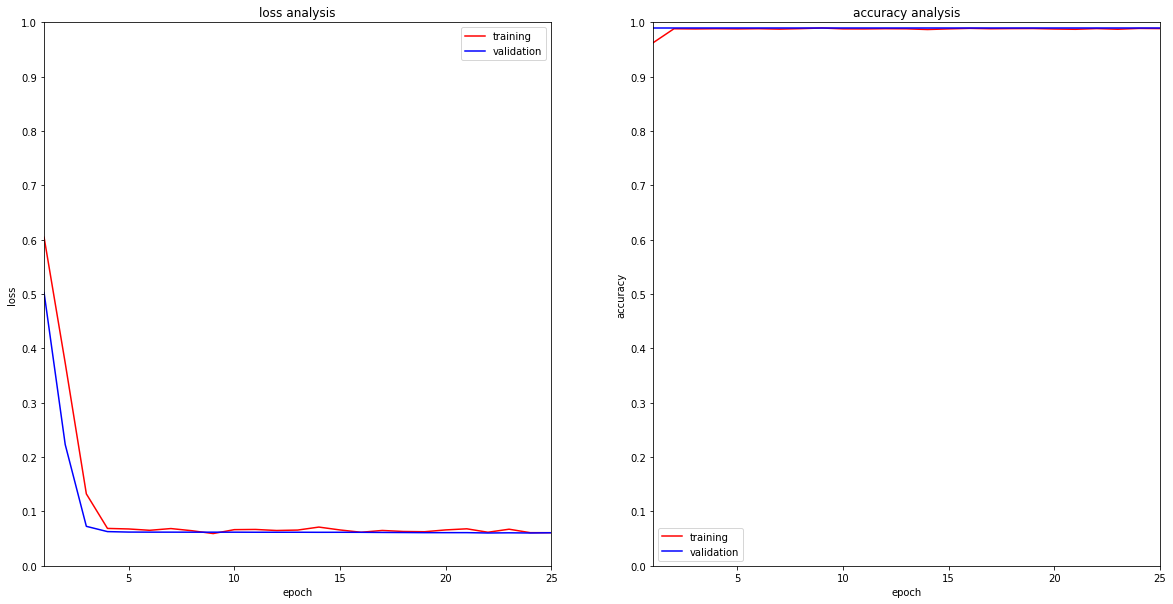

In [11]:
analyze_performances(hst, n_epochs)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


/home/flavia/.virtualenvs/farejadordefake/lib/python3.6/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in true_divide
/home/flavia/.virtualenvs/farejadordefake/lib/python3.6/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


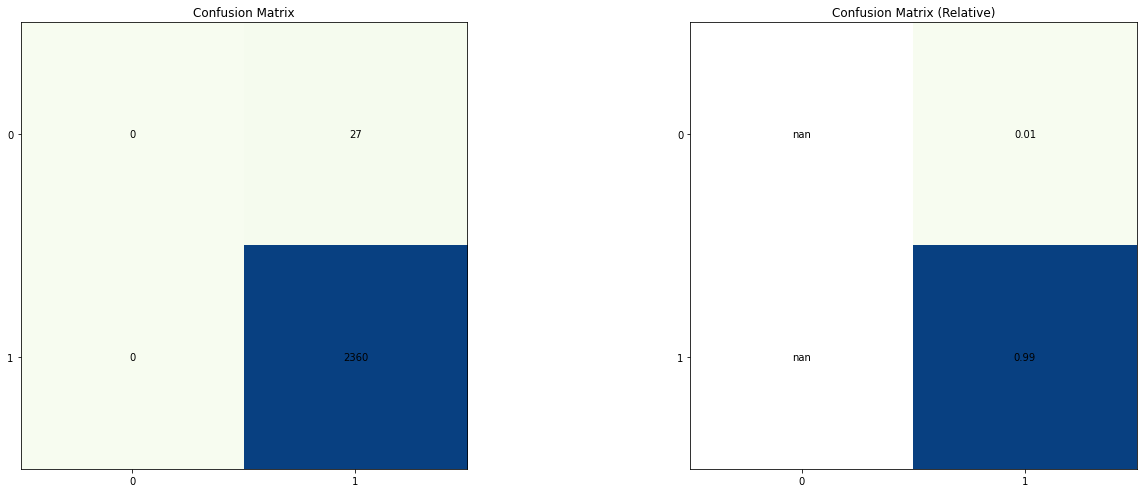

In [12]:
model_evaluation(model, x_test, y_test)